In [222]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pyFTS.benchmarks import Measures
import math
from pyFTS.common import Util
import datetime
import statistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Aux functions

In [223]:
# # convert series to supervised learning
# def series_to_supervised_miso(data, n_in, n_out, endog_var, dropnan=True):
# 	"""
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 		Pandas DataFrame of series framed for supervised learning.
# 	"""
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = pd.DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df[endog_var].shift(-i))
# 		if i == 0:
# 			names += [(endog_var+'(t)')]
# 		else:
# 			names += [(endog_var+'(t+%d)' % (i))]
# 	# put it all together
# 	agg = pd.concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg

## Dataset Energy Appliances

In [224]:
dataset = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = dataset.drop(labels=['date','rv1','rv2'], axis=1)
values = data.values
#values

## Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [225]:
# cols = data.columns
# list_cols = list(cols)

In [227]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
data_scaled = pd.DataFrame(scaled, columns=list_cols)
# frame as supervised learning
#data = series_to_supervised_miso(df_scaled, 1, 1,endog_var='Appliances')
data_scaled.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.173329,0.661412,0.223032,0.677290,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462
1,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.173329,0.660155,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937
2,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.173329,0.655586,0.219563,0.676049,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412
3,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.164175,0.650788,0.219563,0.671909,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887
4,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.164175,0.650788,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362


In [244]:
data.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


## Model: SARIMAX

### Define SARIMAX parameters

In [229]:
values = data.values
values.shape

(19735, 26)

In [282]:
values = data.values
train_size=int(len(values)*0.3)
test_size = int(len(values)) - train_size
print(test_size)

13815


In [283]:
# split into train and test sets
train_X, train_y = data.loc[:,'Appliances':'Tdewpoint'].values[:train_size], data['Appliances'].values[:train_size]
test_X, test_y = data.loc[:,'Appliances':'Tdewpoint'].values[train_size:], data['Appliances'].values[train_size:]

train_y.reshape(-1)
test_y.reshape(-1)

# # split into input (all columns exceptc last one) and outputs (last column)
# train_X, train_y = train_X[:, :-1], train_y[:, -1]
# test_X, test_y = test_X[:, :-1], test_y[:, -1]

# # reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
# train_X = train_X.reshape((train_X.shape[0],train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5920, 26) (5920,) (13815, 26) (13815,)


In [284]:
# cols = data.columns
# list_cols_exog = list(cols)
# list_cols_exog.remove("Appliances(t)")

In [285]:
# df_train_X = pd.DataFrame(train_X,columns=list_cols_exog)
# df_test_X = pd.DataFrame(train_X,columns=list_cols_exog)

In [286]:
# list_cols_endog = []
# list_cols_endog.append('Appliances(t)')
# df_train_y = pd.DataFrame(train_y,columns=list_cols_endog)
# df_test_y = pd.DataFrame(test_y,columns=list_cols_endog)
# #df_train_y

In [287]:
train_y.shape

(5920,)

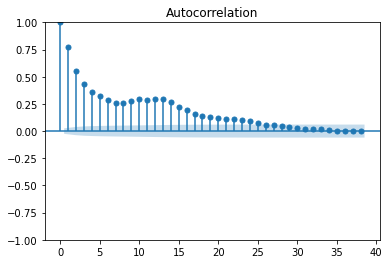

In [288]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_y)
pyplot.show()

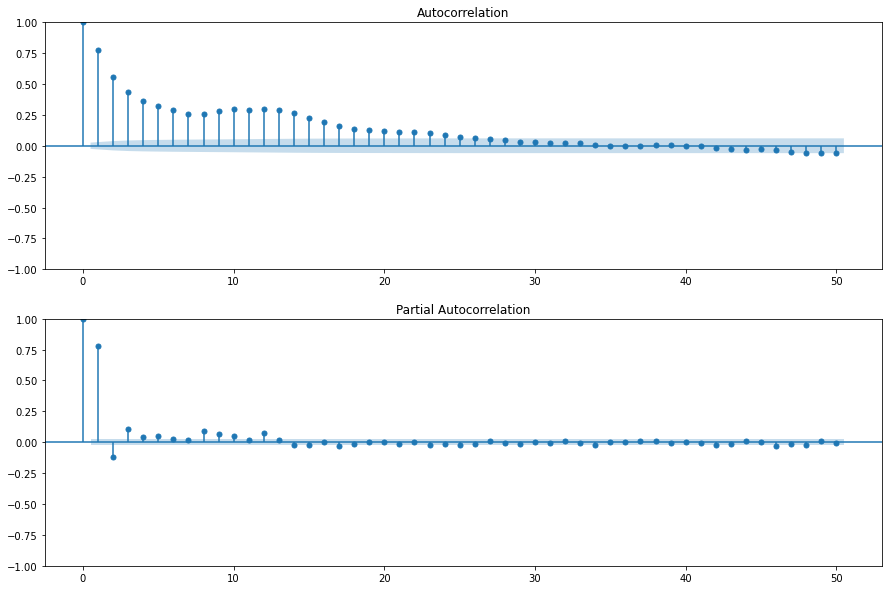

In [289]:
#Correlograms
fig,ax= plt.subplots(2,1, figsize=(15,10))
fig=sm.tsa.graphics.plot_acf(train_y, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(train_y, lags=50, ax=ax[1])
plt.show()

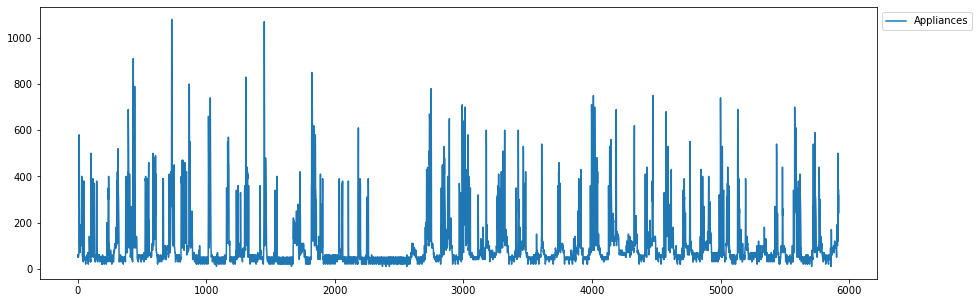

In [290]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
ax.plot(train_y, label='Appliances')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [291]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.pyplot as plt
# result = seasonal_decompose(train_y,model='add',period=365)
# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(30,15))
# result.trend.plot(ax=ax1)
# result.resid.plot(ax=ax2)
# result.seasonal.plot(ax=ax3)

In [292]:
# from pmdarima.arima import auto_arima
# step_wise=auto_arima(train_y, 
#  exogenous= train_X,
#  start_p=1, start_q=1, 
#  max_p=3, max_q=3, 
#  d=1, max_d=3,
#  trace=True, 
#  error_action='ignore', 
#  suppress_warnings=True, 
#  stepwise=True,
#  seasonal=True)

In [293]:
# m = 7 => daily
# m = 54 => weekly
# sarimax_model = auto_arima(train_y,
#                        exogenous= train_X,
#                        test='adf'
#                        start_p=1,
#                        start_q=1,
#                        max_p=3,
#                        max_q=3,
#                        m=7,
#                        seasonal=True,
#                        d=None,
#                        D=1,
#                        trace=True,
#                        error_action='ignore',
#                        suppress_warnings=True,
#                        stepwise=True)

In [294]:
# # m = 7 => daily
# # m = 52 => weekly
sarimax_model = auto_arima(train_y,
                       exogenous= train_X,
                       test='adf',
                       start_p=0,
                       start_q=0,
                       max_p=5,
                       max_q=5,
                       start_Q=0,
                       start_P=0,
                       max_P=5,
                       max_Q=5,
                       m=52,
                       seasonal=True,
                       d=None,
                       D=1,
                       max_D=5,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True,
                       n_fits = 50)

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [20]:
# Best model:  ARIMA(0,0,1)(0,1,2)[12] intercept
#ARIMA(0,0,1)(1,1,2)[7] 
# Total fit time: 11753.701 seconds

# Best model:  ARIMA(0,0,1)(1,1,2)[7] intercept
# Total fit time: 5686.746 seconds

# Best model:  ARIMA(0,0,1)(0,1,1)[4] intercept
# Total fit time: 1330.512 seconds

# Best model:  ARIMA(0,0,1)(0,1,1)[7]          
# Total fit time: 5811.561 seconds

# Best model:  ARIMA(0,0,1)(1,1,2)[7] intercept
# Total fit time: 5686.746 seconds

#sarimax_model.summary()

In [21]:
## order=(3, 1, 2) ==> parameters already used 

In [143]:
# Bons resultados 
#order=(1,0,1), seasonal_order=(1,1,2,7),==> 81.99098	41.067328	44.562429	12.261336
#order=(0,0,1),seasonal_order=(1,1,2,7), ==> 64.766849	29.142376	24.884302	11.20018
#order=(0,0,1), seasonal_order=(0,1,2,7),==> 64.749228	29.107727	24.8284	11.160749
#order=(0,0,1), seasonal_order=(0,1,1,7), ==> 64.748083	29.171255	24.970446	11.202162
#order=(0,0,1), seasonal_order=(0,0,1,7),==> 64.749226	29.10804	24.828806	11.161166

from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(endog=train_y, 
 exog=train_X,
 order=(3,1,2),
 seasonal_order=(0,1,2,7),
 enforce_invertibility=False, 
 enforce_stationarity=False)

In [144]:
results = model.fit(disp=True)

/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [162]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                14800
Model:             SARIMAX(3, 1, 2)x(0, 1, 2, 7)   Log Likelihood               19464.435
Date:                           Fri, 17 Sep 2021   AIC                         -38860.869
Time:                                   00:25:03   BIC                         -38602.446
Sample:                                        0   HQIC                        -38775.065
                                         - 14800                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.2936      0.012    -24.328      0.000      -0.317      -0.270
x2            -0.0228      0.005     -4.751      0.000      -0.032      -0.013
x3            -0.2717      0.084     -3.252      0.001      -0.435      -0.108
x4            -0.3958      0.029    -13.776      0.000      -0.452      -0.339
x5             0.1630      0.073      2.246      0.025       0.021       0.305
x6             0.1560      0.053      2.959      0.003       0.053       0.259
x7            -1.4005      0.076    -18.531      0.000      -1.549      -1.252
x8            -0.0708      0.047     -1.513      0.130      -0.163       0.021
x9            -0.4298      0.049     -8.700      0.000      -0.527      -0.333
x10            0.1988      0.054      3.700      0.000       0.094       0.304
x11         8.493e-05      0.055      0.002      0.999      -0.108       0.108
x12           -0.0216      0.019     -1.138      0.255      -0.059       0.016
x13            0.0889      0.096      0.928      0.353      -0.099       0.277
x14            0.0038      0.038      0.101      0.920      -0.071       0.078
x15            0.4136      0.093      4.463      0.000       0.232       0.595
x16           -0.1656      0.070     -2.360      0.018      -0.303      -0.028
x17           -0.0821      0.079     -1.042      0.297      -0.236       0.072
x18           -0.0300      0.067     -0.450      0.653      -0.161       0.101
x19           -0.0256      0.112     -0.229      0.819      -0.245       0.194
x20           -0.2745      0.048     -5.667      0.000      -0.369      -0.180
x21           -0.1835      0.368     -0.499      0.618      -0.904       0.537
x22           -0.6709      0.120     -5.611      0.000      -0.905      -0.437
x23           -0.1638      0.174     -0.941      0.347      -0.505       0.177
x24            0.0052      0.029      0.181      0.856      -0.051       0.062
x25           -0.0154      0.012     -1.233      0.218      -0.040       0.009
x26            0.3201      0.254      1.258      0.208      -0.179       0.819
ar.L1          1.7380      0.014    126.318      0.000       1.711       1.765
ar.L2         -1.0595      0.020    -53.076      0.000      -1.099      -1.020
ar.L3          0.3144      0.011     29.126      0.000       0.293       0.336
ma.L1         -2.4428      0.031    -79.198      0.000      -2.503      -2.382
ma.L2          1.4438      0.031     46.599      0.000       1.383       1.505
ma.S.L7       -1.1159      0.007   -171.502      0.000      -1.129      -1.103
ma.S.L14       0.1166      0.006     17.999      0.000       0.104       0.129
sigma2         0.0020   8.48e-05     23.480      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                  18.36   Jarque-Bera (JB):            252107.27
Prob(Q):                              0.00   Prob(J

In [163]:
steps = -1
yhat = results.predict(start=train_size, end=train_size+test_size+(steps),exog=test_X)
#yhat

In [164]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual - observed data
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

(4934, 26)


In [165]:
rmse = Measures.rmse(inv_yhat,inv_y)
mape = Measures.mape(inv_yhat,inv_y)
smape = Measures.smape(inv_yhat,inv_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test SMAPE: %.3f' % smape)

Test RMSE: 268.680
Test MAPE: 235.188
Test SMAPE: 61.853


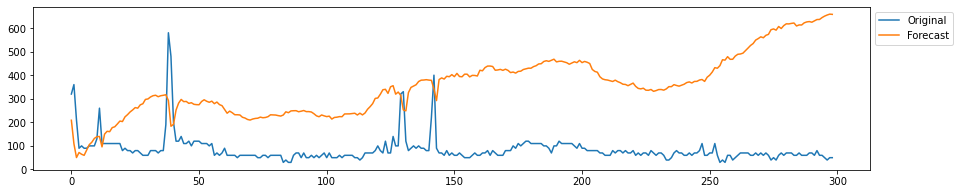

In [166]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(inv_y[1:300], label='Original')
ax.plot(inv_yhat[1:300], label='Forecast')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

## Model: SARIMAX - Final model

In [264]:
def train_sarimax(endog, exog, order, seasonal_order):
    model=sm.tsa.SARIMAX(endog = endog, exog = exog, 
                          order=(0,0,1),
                          seasonal_order=(0,1,2,7), 
                         enforce_invertibility=False, 
                         enforce_stationarity=False)
    sarimax = model.fit()
    return sarimax


def test_sarimax(model,start,end,exog):
    forecasts = model.predict(start=start, end=end, exog=exog)
    return forecasts
    

In [265]:
def transform_original(test_X,test_y,yhat):
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual - observed data
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
    ax.plot(inv_y, label='Original')
    ax.plot(inv_yhat, label='Forecast')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
    plt.show()
    
    return inv_y,inv_yhat

## Sliding Window PyFTS: SARIMAX

--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:27:51] getting statistics


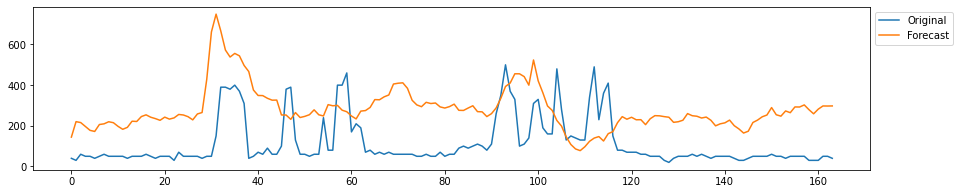

--------------------
training window 657


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:28:20] getting statistics


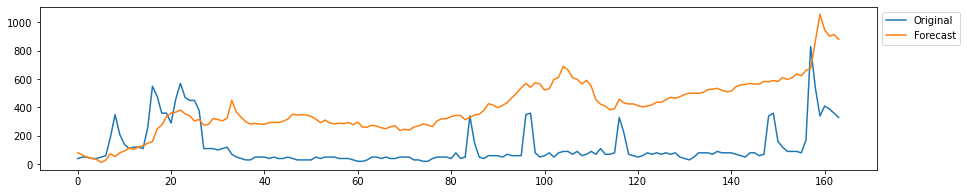

--------------------
training window 1314


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:28:50] getting statistics


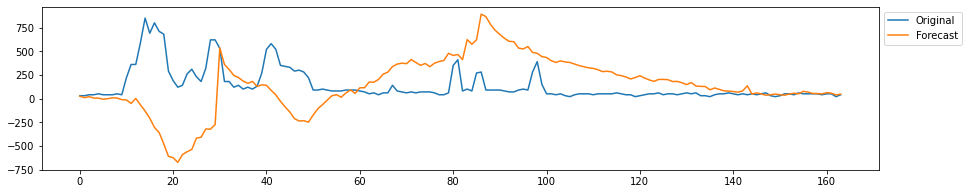

--------------------
training window 1971


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:29:23] getting statistics


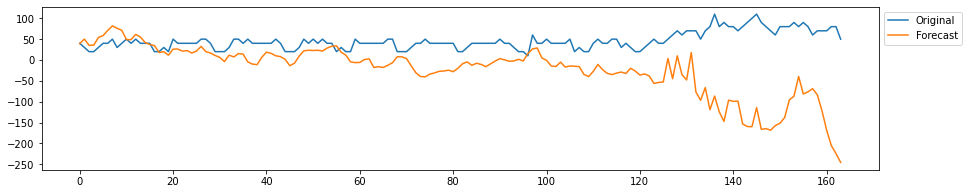

--------------------
training window 2628


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:29:53] getting statistics


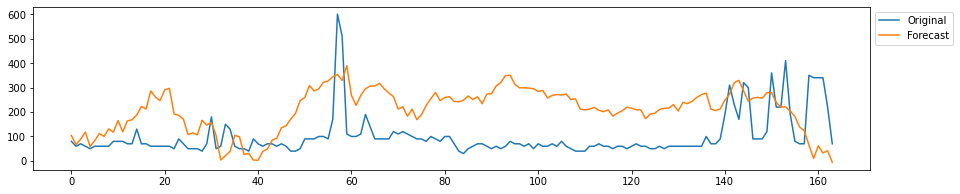

--------------------
training window 3285


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:30:28] getting statistics


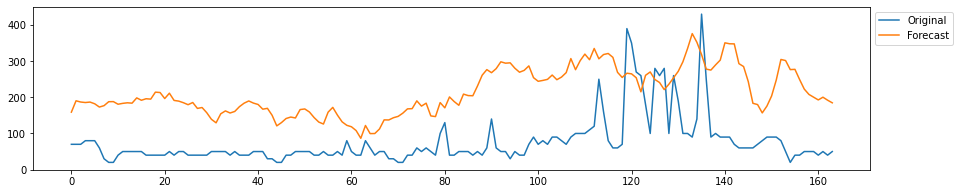

--------------------
training window 3942


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:30:58] getting statistics


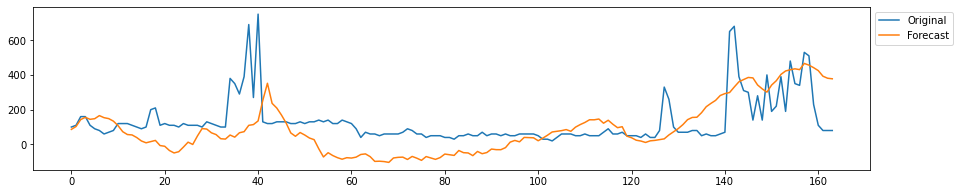

--------------------
training window 4599


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:31:29] getting statistics


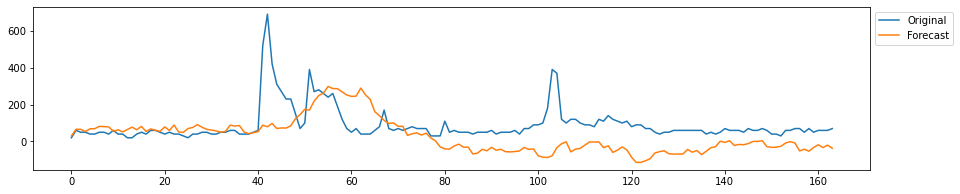

--------------------
training window 5256


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:32:00] getting statistics


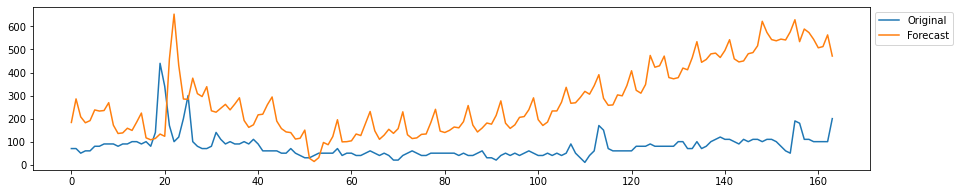

--------------------
training window 5913


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:32:32] getting statistics


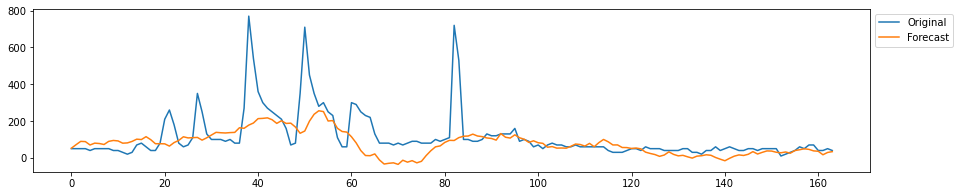

--------------------
training window 6570


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:32:58] getting statistics


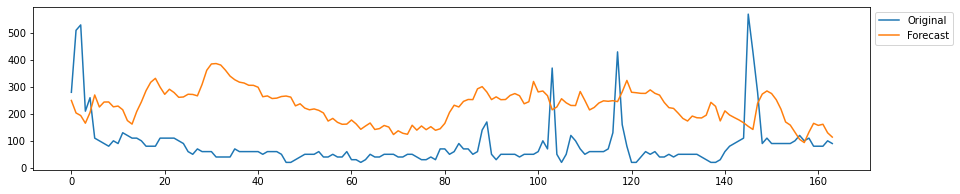

--------------------
training window 7227


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:33:25] getting statistics


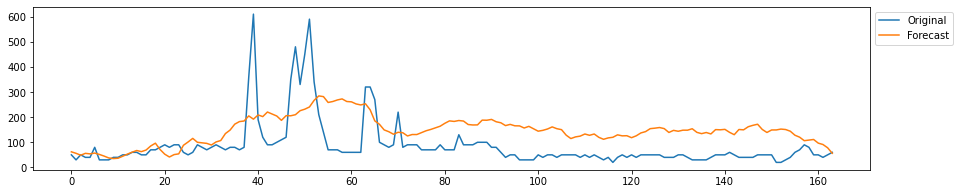

--------------------
training window 7884


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:33:51] getting statistics


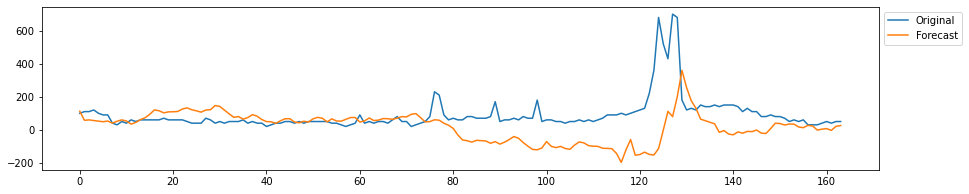

--------------------
training window 8541


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:34:20] getting statistics


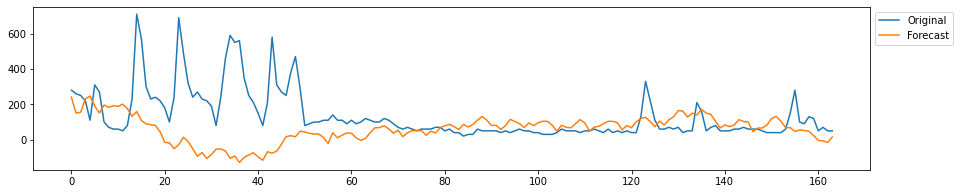

--------------------
training window 9198


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:34:47] getting statistics


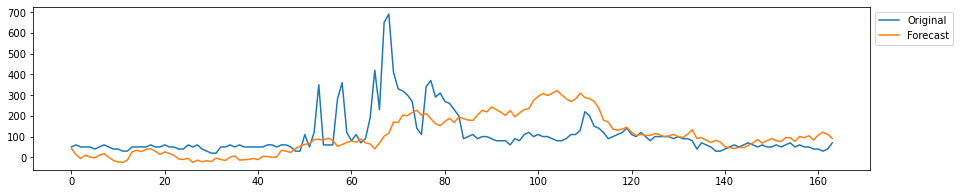

--------------------
training window 9855


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:35:09] getting statistics


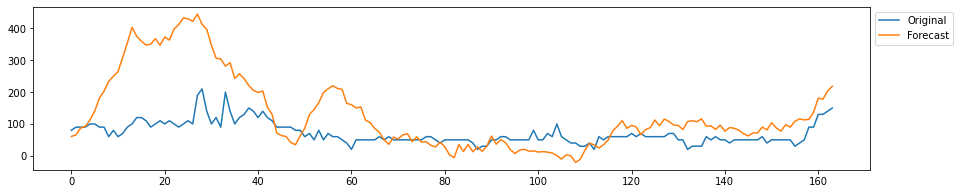

--------------------
training window 10512


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:35:29] getting statistics


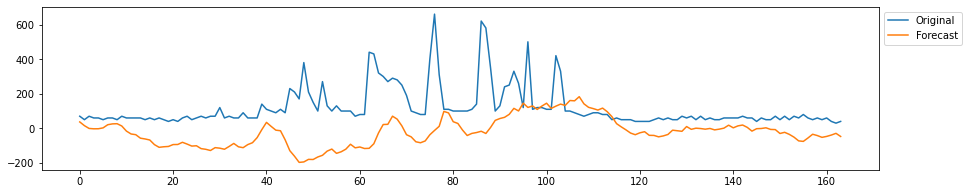

--------------------
training window 11169


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:35:51] getting statistics


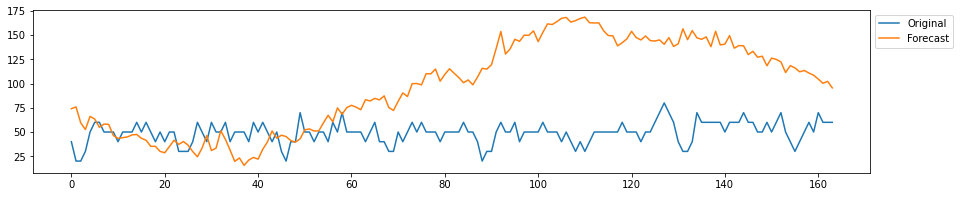

--------------------
training window 11826


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:36:17] getting statistics


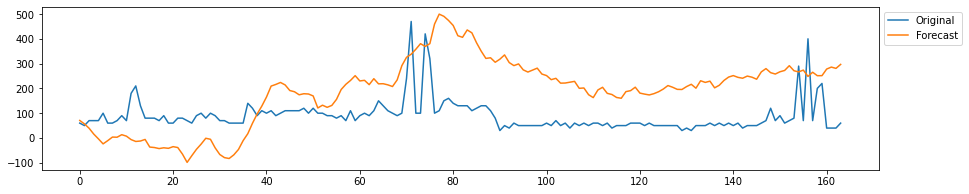

--------------------
training window 12483


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:36:40] getting statistics


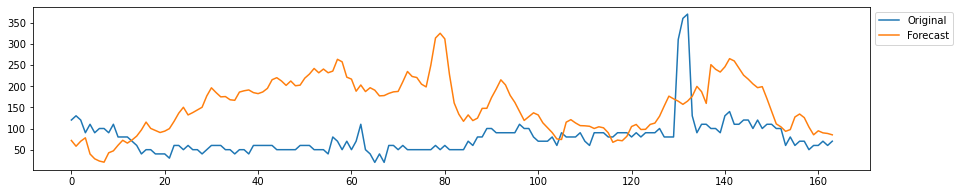

--------------------
training window 13140


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:37:03] getting statistics


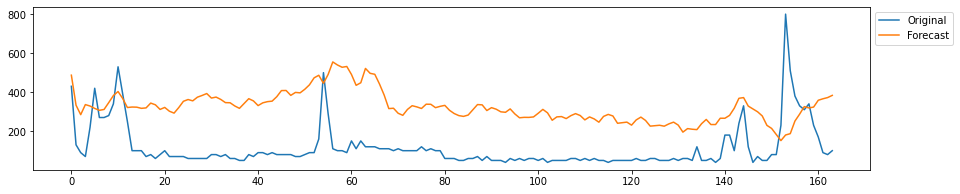

--------------------
training window 13797


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:37:25] getting statistics


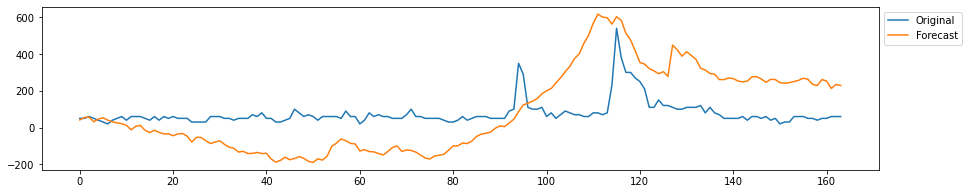

--------------------
training window 14454


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:37:47] getting statistics


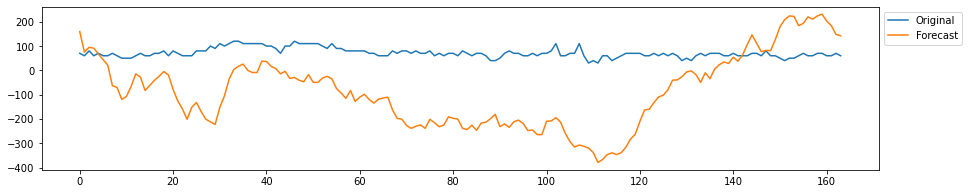

--------------------
training window 15111


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:38:10] getting statistics


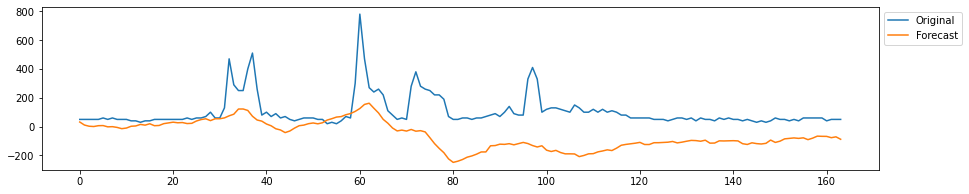

--------------------
training window 15768


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:38:32] getting statistics


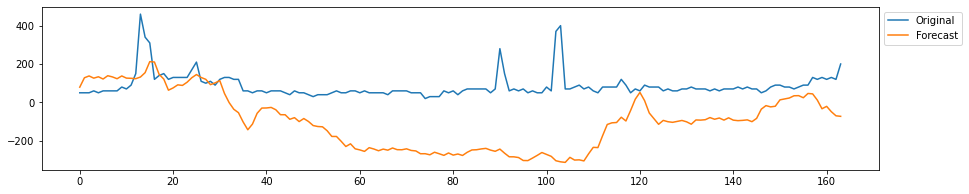

--------------------
training window 16425


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:38:53] getting statistics


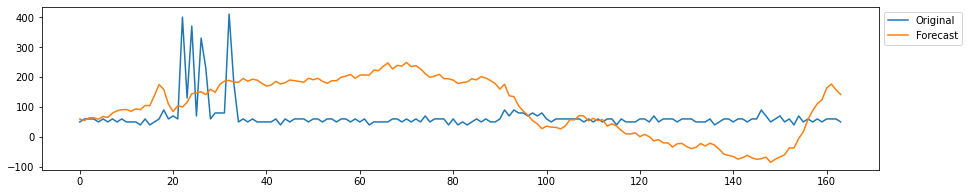

--------------------
training window 17082


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:39:16] getting statistics


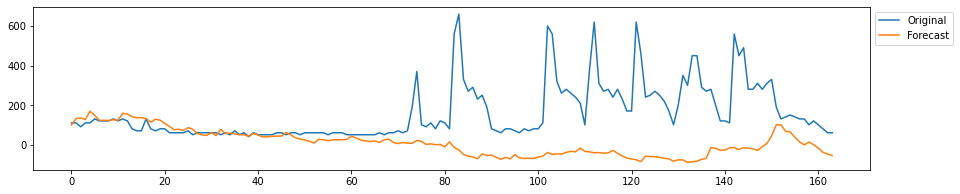

--------------------
training window 17739


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:39:36] getting statistics


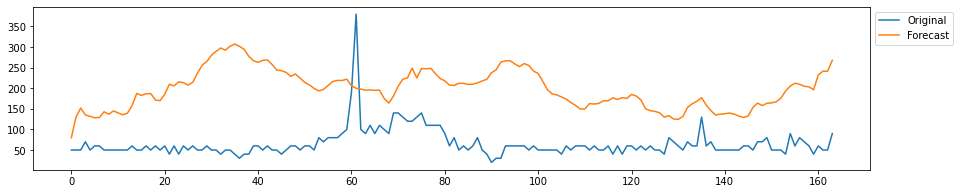

--------------------
training window 18396


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:39:59] getting statistics


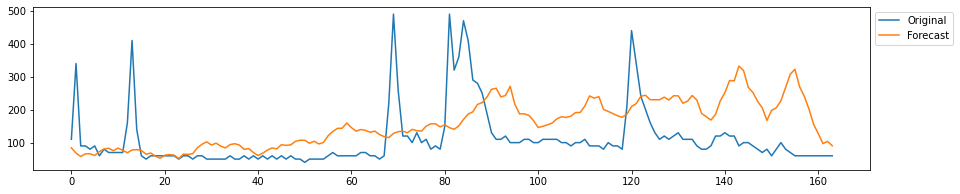

--------------------
training window 19053


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 17:40:22] getting statistics


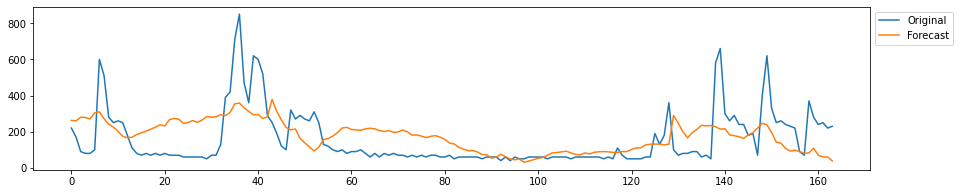

In [267]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data_scaled, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        start = len(ttrain)
        end = len(ttrain)+ len(ttest) -1
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model = train_sarimax(ttrain.loc[:,'Appliances'], ttrain.loc[:,'lights':'Tdewpoint'], [1,0,1], [1,1,2,7])
        yhat = test_sarimax(model, start, end, ttest.loc[:,'lights':'Tdewpoint']) 
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")

        test_X = ttest.loc[:,'Appliances':'Tdewpoint'].values
        test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
        test_y = ttest['Appliances'].values
#         test_y = test_y.values[:len(test_y)-1]
#         test_X = test_X[1:,:]
#         print(test_X.shape)
        appliances,forecast = transform_original(test_X = test_X,test_y = test_y,yhat = yhat.values)
        
        rmse = Measures.rmse(appliances,forecast)
        mape = Measures.mape(appliances,forecast)
        smape = Measures.smape(appliances,forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(appliances, forecast)
                
        result["rmse"].append(rmse)
        result["mae"].append(mae)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)

measures = pd.DataFrame(result)


In [270]:
measures

,window,rmse,mae,mape,smape
0,0,213.126355,194.922679,319.958147,54.359225
1,657,340.624690,304.140968,485.343464,61.090377
2,1314,378.925719,268.890698,280.620973,59.811903
3,1971,102.389974,72.419995,139.152038,75.282881
4,2628,160.253868,142.309577,197.139690,47.283579
5,3285,154.727665,143.196765,277.395371,52.622547
6,3942,149.493354,114.376387,119.995384,54.887147
7,4599,128.713667,94.441813,126.262434,65.358550
8,5256,246.730803,208.116630,314.410746,54.821358
9,5913,115.060163,63.030639,59.141414,33.694375


### Mean Statistics SARIMAX

In [271]:
final_result = {
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mae"].append(statistics.mean(measures['mae']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics SARIMAX (test): ")
final_measures_pca

Mean Statistics SARIMAX (test): 


,rmse,mae,mape,smape
0,174.09573,140.224286,196.560708,54.975258
